# Simulation of a Phased Array
This notebook simulates the electric field of a linearly spaced phased array using ParaProp EM solver. We are simulating a linear transmission phased array bored into the ice of antarctica. This notebook was used to visualize a particular set of parameters in a phased array after using $\verb"ParaPropPhasedArrayOptimization.ipynb"$

#### Notes
* Phased array is constructed using point-like dipoles.
* The verical coordinate z is oriented into the ice as positive.

#### Revision History
* Last revised 10-May-2022 by Leo Deer (deer.279@osu.edu).

### Setting up the simulation

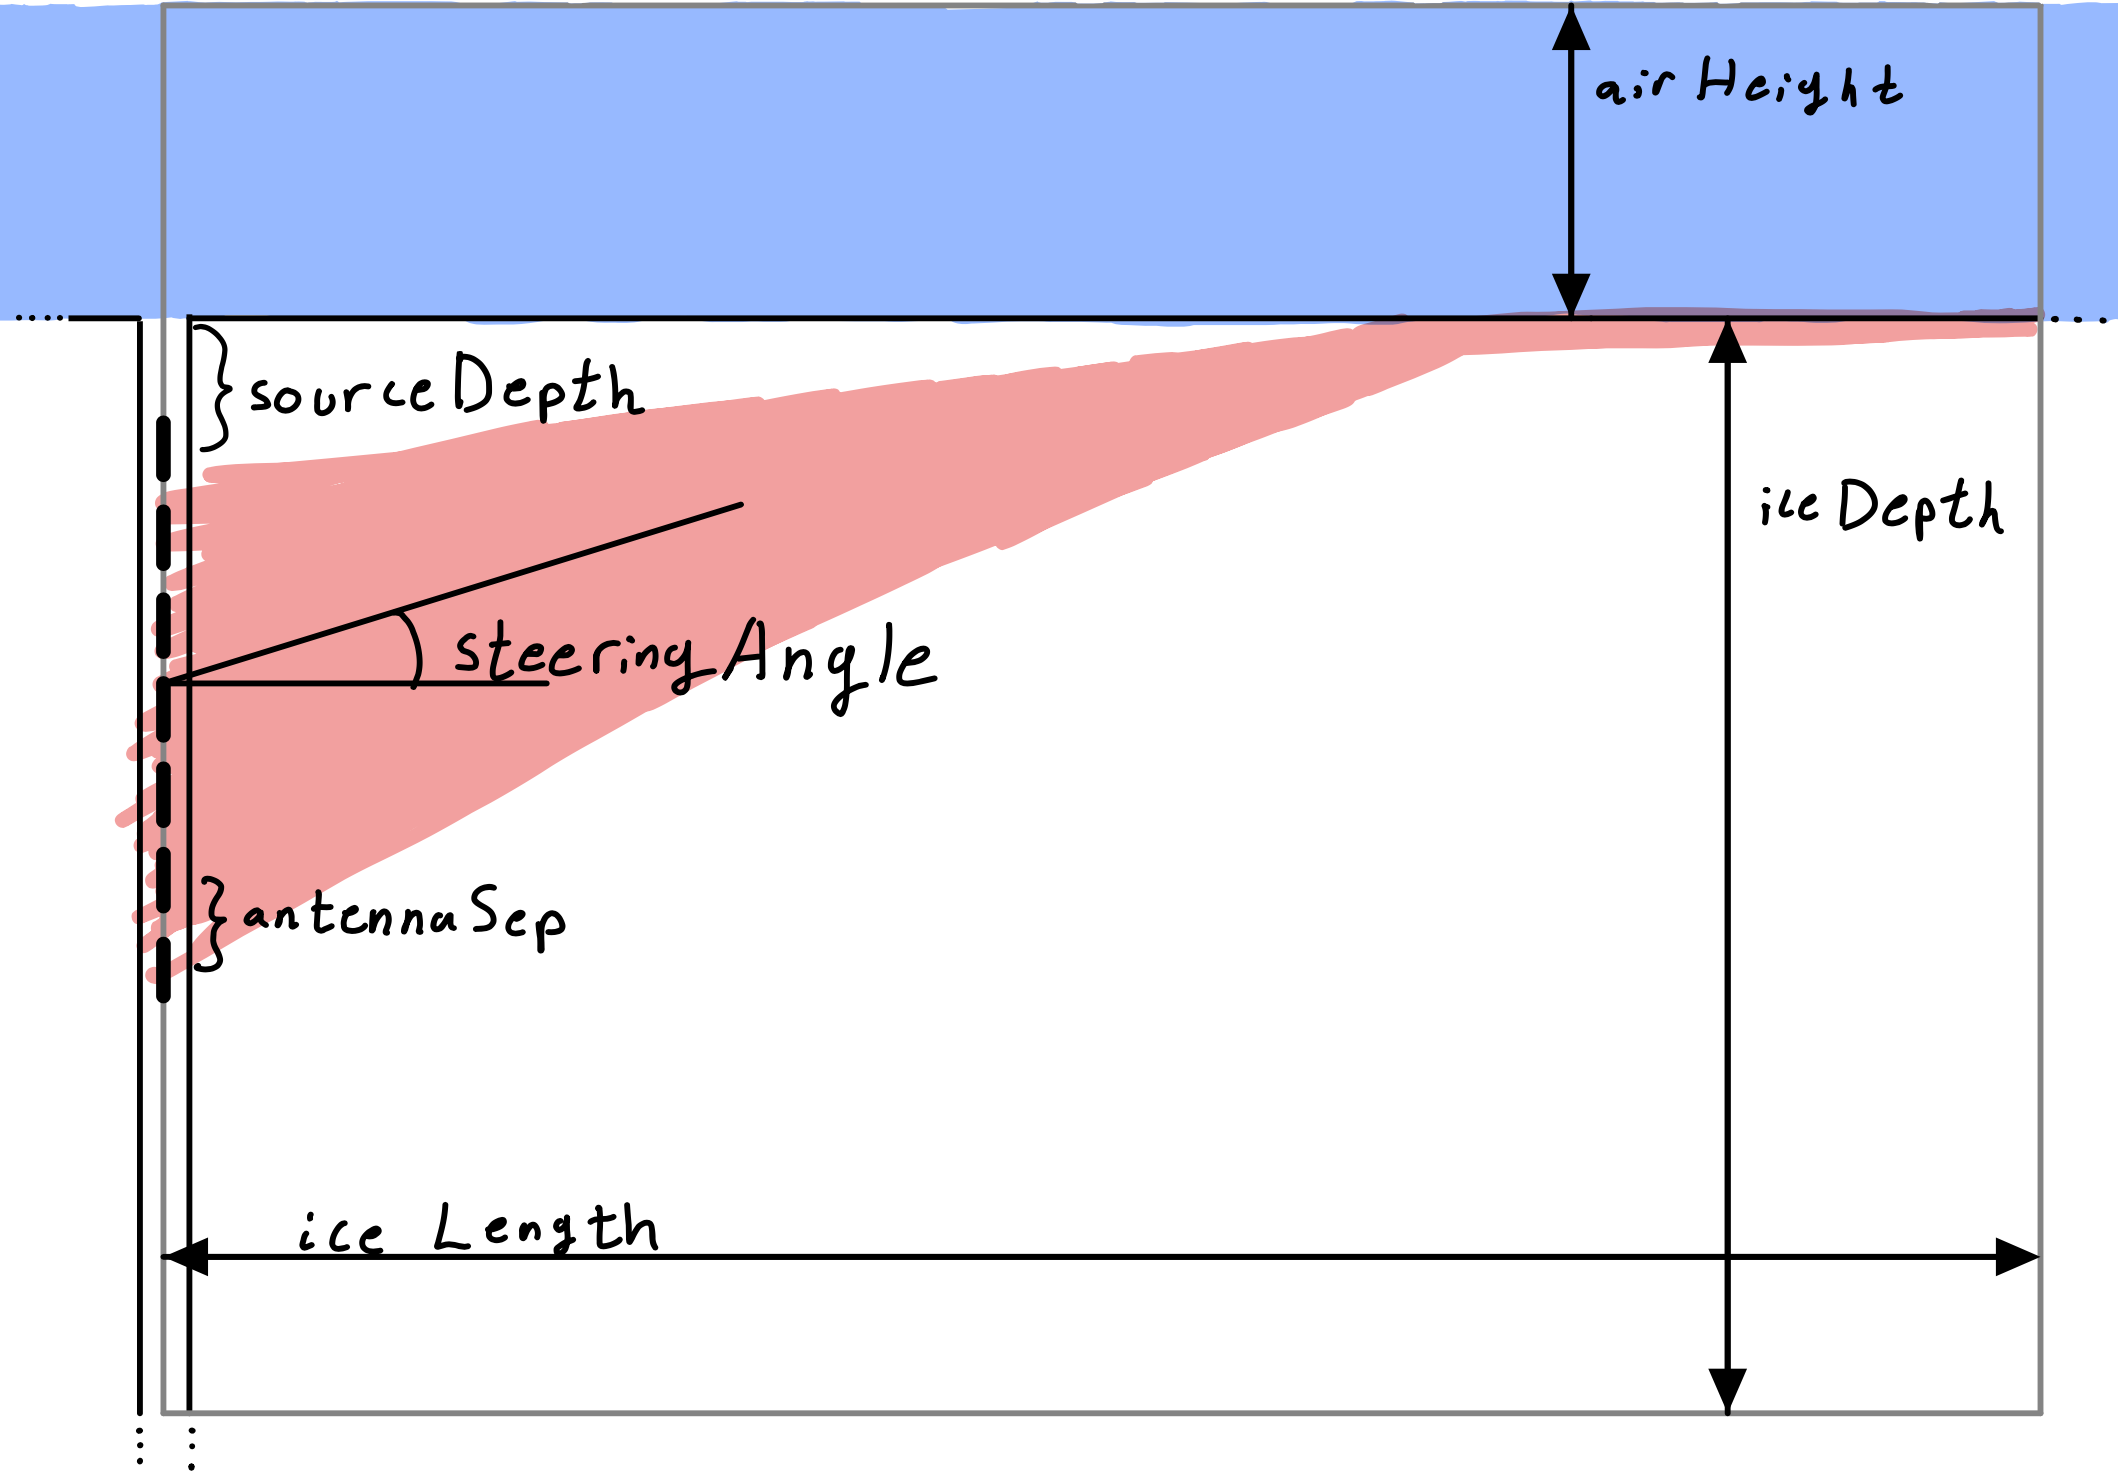

In [1]:
##### importing necessary packages #####

%matplotlib inline
import matplotlib.pyplot as plt
import math
import paraPropPython as ppp
import numpy as np
import util as util

In [25]:
##### setting up parameters and conditions of simulation #####

### first, initialize the dimensions of the simulation ###
airHeight = 0. #height above the surface of the ice (m)
iceDepth = 100. #depth below the surface of the ice (m)
iceLength = 200. #radial length away from the antenna
dx = 0.1 # grid size in the radial direction (m)
dz = 0.1 # grid size in the vertical direction (m)

### next, initialize the phased array specs ###
freq = 0.1 #frequency of phased array signal(GHz)
c = 0.3 #Speed of light (m*GHz)
wl = c/freq #wavelength of phased array signal (m)
k = 2*np.pi/wl #wave number of phased array signal(m^-1)
antennaSep = wl #seperation of dipole elements in phased array
numAntenna = 8 #number of dipole elements in phased array
sourceDepth = 30. # depth of the top dipole of the array (m)
steeringAngle = 0. #steering angle of phased array signal (degrees)

### next, initialize the simulation ###
sim = ppp.paraProp(iceLength, iceDepth, dx, dz, airHeight, refDepth=sourceDepth)
z = sim.get_z()
x = sim.get_x()

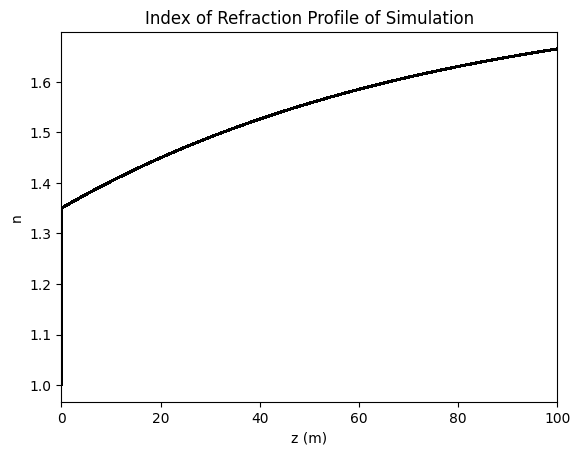

In [26]:
### next, initialize the index of refraction n ###
def southpole(z):
    A=1.78
    B=-0.43
    C=-0.0132
    return A+B*np.exp(C*z)
sim.set_n(nFunc=southpole)

## plot of n ##
plt.plot(z, sim.get_n(), color='black')
plt.ylabel('n')
plt.xlabel('z (m)')
plt.title('Index of Refraction Profile of Simulation')
plt.xlim(z[0], z[-1])
plt.show()

### Initializing the source

In order to steer the electirc field at an angle $\phi$ in vacuum, we apply a phase factor to electric field source of each dipole. The factor on the $l^{th}$ dipole source is, $e^{\left(-il(k\phi d) \right)}$
   - $k$ is the wavenumber of the antenna
   - $d$ is the inter-dipole seperation
<br>

And the depth of the $l^{th}$ dipole source is $ D(l) = D_0 + d\cdot l$
   * $D_0$ is the depth of the top dipole

#### Non-linear phase offsets and spacings
Because the non-linear refractive index of the ice causes the steered electic field to bend down, I have been experimenting with non-linear phase offsets and dipole spacings to try and offset this effect.$\newline$
Instead of the dipole spacing being linear, I added the option for an exponential spacing. The depth of the $l^{th}$ dipole is $ D(l) = D_0 + d\cdot a\cdot (1-e^{-l/a})$
   * $a$ is a new parameter to control the degree of exponentiation
<br>

In addition, I added an option for an similar exponential phase offset. The factor on the $l^{th}$ dipole source is, $e^{\left(-ik\phi d\cdot \left(b \left(1-e^{-l/b}\right)\right)\right)}$
   * $b$ is a new parameter to control the degree of exponentiation

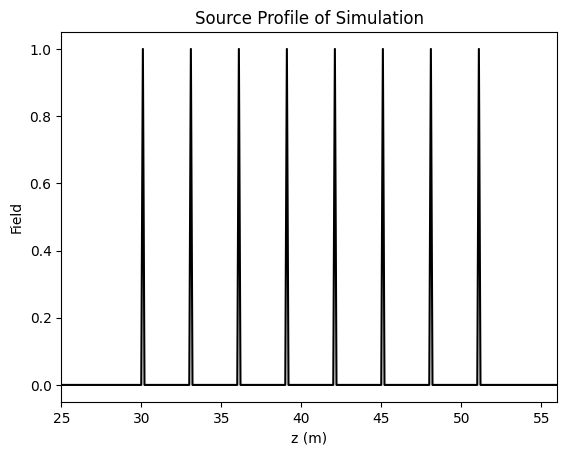

In [27]:
#### adjust exponential spacing and phase parameters, if using ####
a=100
b=15

#### initialize the spacing ####
sourceDepths = []
for i in range(numAntenna):
    #sourceDepths.append(round((sourceDepth + antennaSep*a*(1-math.exp(-i/a)))/dz)) #exponential spacing option
    sourceDepths.append(round(float((sourceDepth + antennaSep*i)/dz))) #linear spacing option
       
#### initialize the phase offset ####
phi = np.deg2rad(steeringAngle) #convert steeringAngle to radians
arraySize = round(iceDepth - sourceDepth)
#arraySize = round(iceDepth)
sourceArray = []
for i in range(int(arraySize/dz)):
    sourceArray.append(0)
for l in range(len(sourceDepths)):
    #sourceArray[sourceDepths[l]] = np.exp((-1j)*k*antennaSep*((b)*(1-math.exp(l/b)))*phi) #exponential phase option
    sourceArray[sourceDepths[l]] = np.exp((-1j)*k*antennaSep*l*phi) #linear phase option

#### create source profile ####
sim.set_user_source_profile('vector', z0=0, sVec=sourceArray, sFunc=None)
sim.set_cw_source_signal(freq)

#### plot the source ####
plt.plot(z, abs(sim.get_source_profile()), color='black')
plt.ylabel('Field')
plt.xlabel('z (m)')
plt.title('Source Profile of Simulation')
plt.xlim(sourceDepth - 5, sourceDepth + int((sourceDepths[-1]-sourceDepths[0])*dz) + 5)
plt.show()

In [28]:
### run the solver ###
sim.do_solver()

#### relevant quantities ####

eField = np.transpose(abs(sim.get_field()))
eNormalize = np.amax(eField)
normEField = eField/eNormalize

### Plotting
I will plot the magnitude of the E-field.

Becuase the units of E-Field are weird, I will plot a normalized E-field. I will normalize such that the E-field maximum value is 1.

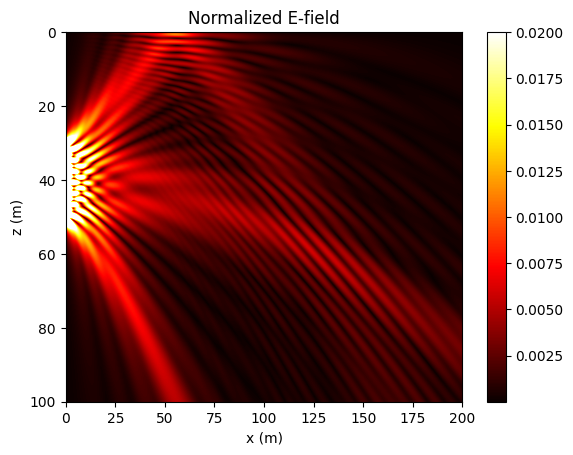

In [33]:
#### plot the field over the whole simulation space ####
fig = plt.figure()
ax = fig.add_subplot(111)

plt.imshow(normEField, aspect='auto', cmap='hot',  vmin=1e-5, vmax=2e-2, 
          extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.xlabel("x (m)")
plt.ylabel("z (m)")
plt.title("Normalized E-field")
plt.show()
fig.savefig('PhasedArray'+str(int(sourceDepth))+str(int(steeringAngle))+'EField.png')

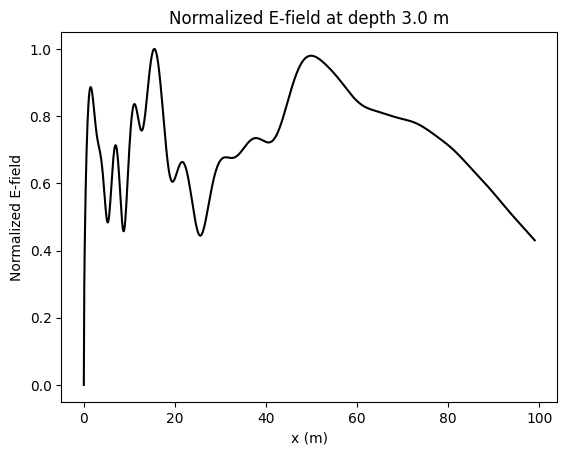

In [7]:
#### plot a horizontal slice of field####
z0 = 3. #the depth of the field the horizontal slice shall be taken
eNormalizeVSlice = np.amax(abs(sim.get_field(z0=z0)))
normEFieldVSLice = abs(sim.get_field(z0=z0))/eNormalizeVSlice

plt.plot(x, normEFieldVSLice, color='black')
plt.xlabel('x (m)')
plt.ylabel('Normalized E-field')
plt.title("Normalized E-field at depth " + str(z0) + " m" )
plt.show()

In [ ]:
#### plot a vertical slice of field####
x0 = 50. #the range of the field the vertical slice shall be taken
eNormalizeHSlice = np.amax(abs(sim.get_field(x0=x0)))
normEFieldHSLice = abs(sim.get_field(x0=x0))/eNormalizeHSlice

plt.plot(z, normEFieldHSLice, color='black')
plt.xlabel('z (m)')
plt.ylabel('Normalized E-field')
plt.title("Normalized E-field at range " + str(x0) + " m" )
plt.show()